If needed, the hardcoded values and bounds in the following cell can be changed. The script assumes there is a file called data.npz which contains data headers: voltage, power and soc. We also assume time ticks are 1 second.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_tools.query import DBClient 
from data_tools.collections import TimeSeries
import datetime

from dotenv import load_dotenv

load_dotenv()

ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_USERNAME in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_PASSWORD in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_DATABASE in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_ADDRESS in .env!


True

In [2]:
client = DBClient(influxdb_token="s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==", influxdb_org="8a0b66d77a331e96")

start = datetime.datetime.fromisoformat("2025-04-11T00:00:00Z")
stop = datetime.datetime.fromisoformat("2025-04-14T00:00:00Z")

pack_voltage = client.query_time_series(start=start, stop=stop, field="TotalPackVoltage", bucket="CAN_log", granularity=0.1, units="V", car="Brightside")
pack_current = client.query_time_series(start=start, stop=stop, field="PackCurrent", bucket="CAN_log", granularity=0.1, units="A", car="Brightside")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


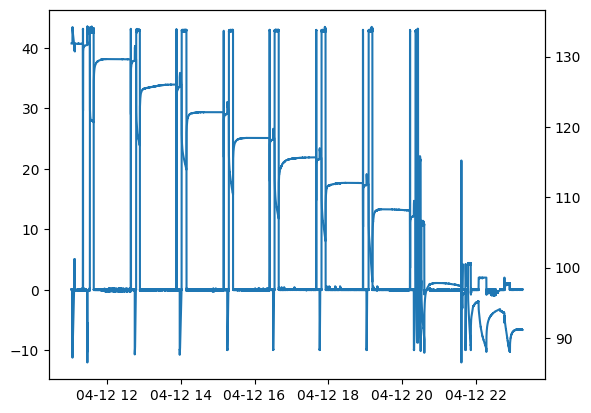

In [3]:
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax.plot(pack_current.datetime_x_axis, pack_current)
ax2.plot(pack_voltage.datetime_x_axis, pack_voltage)
plt.show()

In [4]:
I_load, U_measured = TimeSeries.align(pack_current, pack_voltage)

# This notebook uses the opposite convention -> negative power = discharging
# InfluxDB and firmware uses the convention where -> positive power = discharging
power = U_measured * -I_load
power -= 2           # ~2 watts of power draw for LEDs, contactors, etc

N = len(U_measured)  # Number of data points

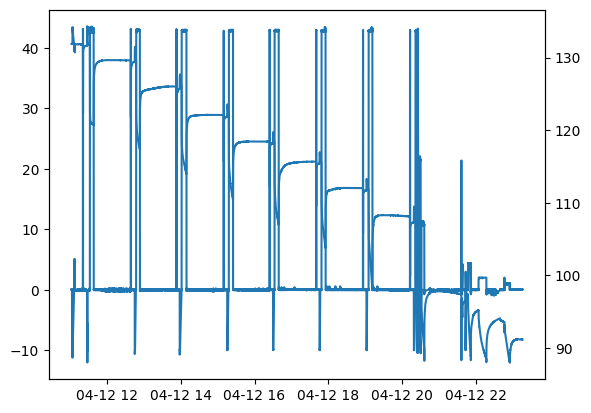

In [5]:
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax.plot(I_load.datetime_x_axis, I_load)
ax2.plot(U_measured.datetime_x_axis, U_measured)
plt.show()

We need to identify the SOC that we performed each pulse at; since the battery was relaxed before the pulse begins, we can read it off from the voltage. For this, I'm stealing Jonah's SOC from voltage interpolation code.

I'm going to manually read off indices that are from right before a pulse, and index the SoC from interpolation at those indices.


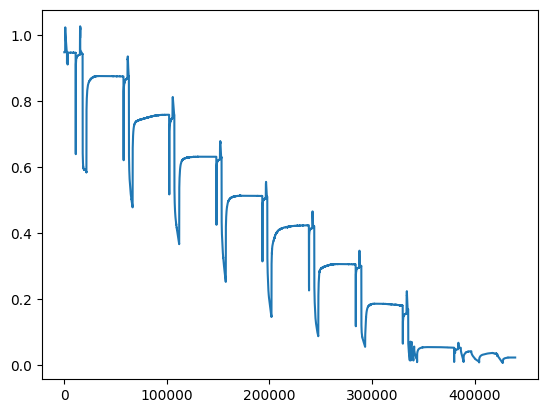

In [11]:
from soc_analysis.datasheet_voltage_soc.soc_from_voltage import cell_soc_from_voltage
from soc_analysis.soc import get_soc_from_voltage_at_relaxation

num_modules = 32

# soc_from_interpolation = cell_soc_from_voltage(U_measured / num_modules)
soc_from_interpolation = get_soc_from_voltage_at_relaxation(U_measured)

# %matplotlib notebook
plt.plot(soc_from_interpolation)

In [16]:
soc_indices = [421210, 379410, 329816, 284051, 238416, 192883, 148060, 100789, 56830, 8274]
SOC_data = soc_from_interpolation[soc_indices]

In [17]:
SOC_data

array([0.03544889, 0.05358507, 0.1813238 , 0.30576348, 0.42408743,
       0.51289267, 0.63165696, 0.75885687, 0.8749149 , 0.94667201])

We need a few more constants.

In [18]:
# Hardcoded values
Q_estimated = 3300 * 13 * 3.6     # 3300mAh per cell * 32 modules * 12 cells per module * 1 Ah / 1000mAh = Charge Capacity in Ah 
max_current_capacity = 42.9         # 42.9 A max current
max_energy_capacity = 500           # This is not actually used by the battery model, so I set it arbitrarily.

# Bounds derived from conventional battery ranges
initial_guess = (
    [0.2564, 0.2541, 0.2541, 0.2558, 0.2549, 0.2574, 0.2596, 0.2626, 0.2676, 0.2789] +   # R_0_data (Ohmic Resistance)
    [0.595, 0.449, 0.402, 0.383, 0.386, 0.585, 0.558, 0.530, 0.490, 0.466] +   # R_P_data (Polarization Resistance), 
    [4541, 8362, 9538, 10113, 9525, 7402, 7646, 7327, 7658, 8009] +   # C_P_data (Capacitance)
    [2.8 * 32, 2.9 * 32, 3.1 * 32, 3.3 * 32, 3.45 * 32, 3.750 * 32, 3.846 * 32, 3.946 * 32, 4.056 * 32, 4.183 * 32]              # Uoc_data (Open Circuit Voltage)
)

In [19]:
# Function to plot objective function with initial guess
def plot_results(soc_array, voltage_array, power, U_measured, optimize):
    time = np.arange(len(power))

    plt.figure(figsize=(12, 6))

    # Plot SOC
    plt.subplot(2, 1, 1)
    plt.plot(time, soc_array, label="Predicted State of Charge (SOC)", color="blue")

    plt.xlabel("Time (s)")
    plt.ylabel("SOC (%)")
    if optimize:
        plt.title("Battery Simulation after Optimization: Predicted vs Real State of Charge Over Time")
    else:
        plt.title("Battery Simulation before Optimization: Predicted vs Real State of Charge Over Time")

    plt.grid(True)
    plt.legend()

    # Calculate min/max voltage values
    min_voltage = min(np.min(voltage_array), np.min(U_measured))
    max_voltage = max(np.max(voltage_array), np.max(U_measured))
    margin = (max_voltage - min_voltage) * 0.05  # 5% margin for visibility

    # Plot Voltage
    plt.subplot(2, 1, 2)
    plt.plot(time, voltage_array, label="Predicted Voltage", color="orange")
    plt.plot(time, U_measured, label="Real Voltage", color="red", linestyle="dashed")  # Real voltage added
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    if optimize:
        plt.title("Battery Simulation after Optimization: Predicted vs Real Voltage Over Time")
    else:
        plt.title("Battery Simulation before Optimization: Predicted vs Real Voltage Over Time")


    plt.ylim(min_voltage - margin, max_voltage + margin)  # Adjust Y-axis dynamically
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:
from physics.models.battery import BatteryModel, BatteryModelConfig


def run_battery_model(params, total_charge) -> tuple[np.ndarray, np.ndarray]:
    battery_config = BatteryModelConfig(
        R_0_data=params[:10],  # Optimized R_0_data
        R_P_data=params[10:20],        # Optimized R_P
        C_P_data=initial_guess[20:30],        # Optimized C_P
        Q_total=total_charge,
        SOC_data=SOC_data,     # Hardcoded SOC data
        Uoc_data=initial_guess[30:40],# Optimized Uoc_data
        max_current_capacity=max_current_capacity,
        max_energy_capacity=max_energy_capacity
    )
    bm = BatteryModel(battery_config)
    
    # Run Battery Model
    soc_array, U_predicted = bm.update_array(power, power.granularity, rust=True)

    return soc_array, U_predicted


def objective_soc(total_charge, visualize=True, optimized=False):
    battery_config = BatteryModelConfig(
        R_0_data=initial_guess[:10],  # Optimized R_0_data
        R_P_data=initial_guess[10:20],        # Optimized R_P
        C_P_data=initial_guess[20:30],        # Optimized C_P
        Q_total=total_charge,
        SOC_data=SOC_data,     # Hardcoded SOC data
        Uoc_data=initial_guess[30:40],# Optimized Uoc_data
        max_current_capacity=max_current_capacity,
        max_energy_capacity=max_energy_capacity
    )
    bm = BatteryModel(battery_config)
    
    # Run Battery Model
    soc_array, U_predicted = bm.update_array(power, power.granularity, rust=True)

    # Compute Errors
    mse_soc = np.mean((soc_array[soc_indices] - SOC_data) ** 2)

    # Visualize Results
    if visualize:
        plot_results(soc_array, U_predicted, power, U_measured, optimized)

    return mse_soc

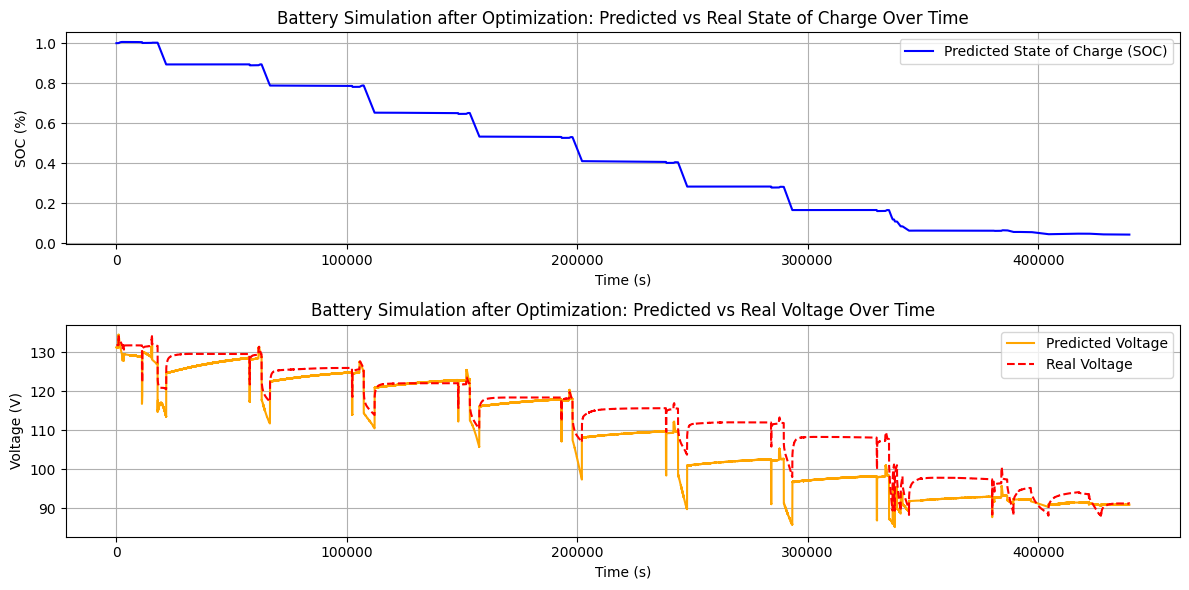


🔹 Optimized Parameters:
- Q_total (C): 139359.261002523

🔹 Final Error (MSE): 6.660662785078e-04



In [22]:
from scipy import optimize

# Define the optimization wrapper function
def optimization_wrapper(charge):
    return objective_soc(charge, visualize=False)  # Run without plotting for efficiency

# Perform optimization using SciPy's minimize Powell method
result = optimize.minimize_scalar(optimization_wrapper, method='bounded', bounds=(Q_estimated / 1.25, Q_estimated * 1.25))
objective_soc(result.x, visualize=True, optimized=True)

formatted_params = f"""
🔹 Optimized Parameters:
- Q_total (C): {result.x}

🔹 Final Error (MSE): {result.fun:.12e}
"""

print(formatted_params)

In [23]:
nominal_charge_capacity = result.x

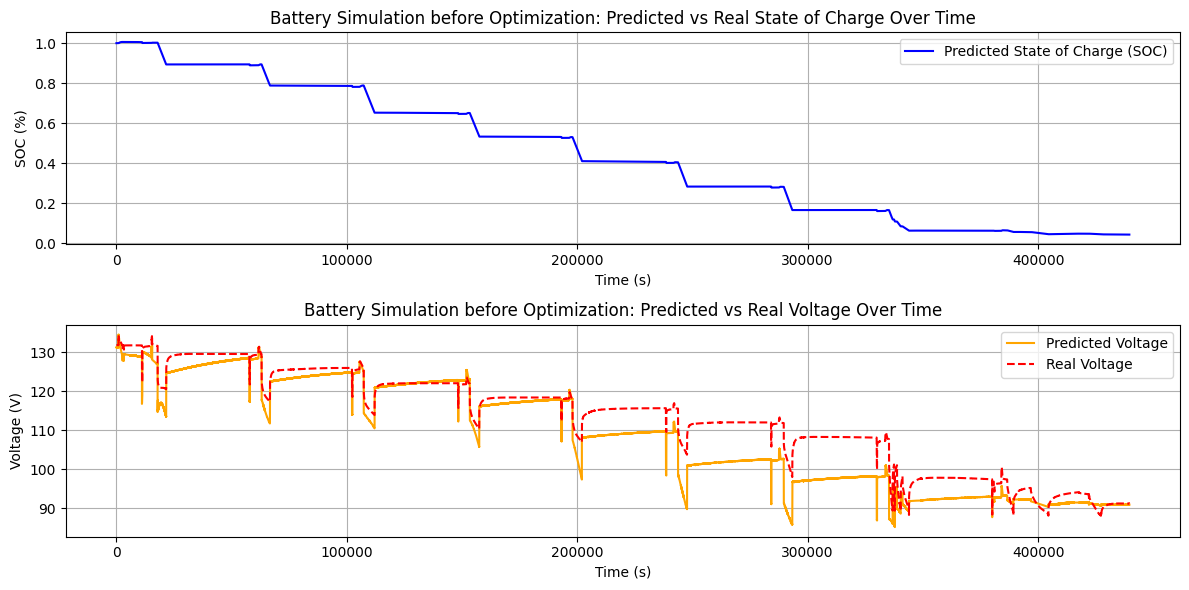

TimeSeries(32.00254666)

In [24]:
# Define the objective function
def objective_voltage(params, visualize=True, optimized=False):
    battery_config = BatteryModelConfig(
        R_0_data=params[:10],  # Optimized R_0_data
        R_P_data=params[10:20],        # Optimized R_P
        C_P_data=params[20:30],        # Optimized C_P
        Q_total=nominal_charge_capacity,
        SOC_data=SOC_data,     # Hardcoded SOC data
        Uoc_data=params[30:40],# Optimized Uoc_data
        max_current_capacity=max_current_capacity,
        max_energy_capacity=max_energy_capacity
    )
    bm = BatteryModel(battery_config)
    
    # Run Battery Model
    soc_array, U_predicted = bm.update_array(power, power.granularity, rust=True)

    # Compute Errors
    mse_voltage = np.mean((U_measured - U_predicted) ** 2)

    # Visualize Results
    if visualize:
        plot_results(soc_array, U_predicted, power, U_measured, optimized)

    return mse_voltage

objective_voltage(initial_guess)

In [43]:
from sklearn.preprocessing import MinMaxScaler
import warnings


# Original (non-normalized) bounds
lower_bounds = np.array(
    [0.0]*10 +          # R_0_data
    [0.0]*10 +          # R_P_data
    [0.0]*10 +          # C_P_data
    [85.0]*10           # U_oc_data
)
upper_bounds = np.array(
    [1.0]*10 +          # R_0_data
    [1.0]*10 +          # R_P_data
    [50000.0]*10 +      # C_P_data
    [135.0]*10          # U_oc_data
)
bounds = list(zip(lower_bounds, upper_bounds))


# Create a scaler to map [lower_bounds, upper_bounds] <-> [0, 1]
scaler = MinMaxScaler()
scaler.fit(np.vstack([lower_bounds, upper_bounds]))  # shape (2, n_features)


# --- Scaled objective function ---
def scaled_objective(scaled_params):
    real_params = scaler.inverse_transform([scaled_params])[0]
    return objective_voltage(real_params, visualize=False)


def make_callback(patience=50, min_delta=1e-6):
    best = {"val": np.inf, "iter": 0, "last_improved": 0}

    def callback(x, convergence):
        best["iter"] += 1
        real_params = scaler.inverse_transform([x])[0]
        loss = objective_voltage(real_params, visualize=False)

        if loss < best["val"] - min_delta:
            print(f"Iter {best['iter']:3d} | Loss: {loss:.6f}")
            best["val"] = loss
            best["last_improved"] = best["iter"]
            
        elif best["iter"] - best["last_improved"] > patience:
            print(f"Early Stopping: No improvement in {patience} iterations...")
            raise StopIteration

    return callback


# --- Define initial guess and scale it ---
initial_guess_scaled = scaler.transform([initial_guess])[0]


# --- Generate tight population around initial guess (±5% of range) ---
def make_initial_population(guess_scaled, num_individuals, noise_scale=0.05):
    population = [guess_scaled]
    for _ in range(num_individuals - 1):
        noise = noise_scale * (np.random.rand(len(guess_scaled)) - 0.5)
        candidate = np.clip(guess_scaled + noise, 0.0, 1.0)
        population.append(candidate)
    return np.array(population)

population_size = 30  # per DE default
num_params = len(initial_guess)
init_population = make_initial_population(initial_guess_scaled, population_size)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    result = optimize.differential_evolution(
        scaled_objective,
        bounds=[(0.0, 1.0)] * len(lower_bounds),
        init=init_population,
        strategy="rand1bin",
        maxiter=500,
        popsize=population_size,
        tol=1e-4,
        mutation=(0.5, 1.0),
        recombination=0.7,
        callback=make_callback(),
        disp=True
    )

differential_evolution step 1: f(x)= 18.412330843781817
Iter   1 | Loss: 18.412331
differential_evolution step 2: f(x)= 18.412330843781817
differential_evolution step 3: f(x)= 18.412330843781817
differential_evolution step 4: f(x)= 17.73737232389889
Iter   4 | Loss: 17.737372
differential_evolution step 5: f(x)= 17.73737232389889
differential_evolution step 6: f(x)= 15.297689842811607
Iter   6 | Loss: 15.297690
differential_evolution step 7: f(x)= 15.297689842811607
differential_evolution step 8: f(x)= 15.297689842811607
differential_evolution step 9: f(x)= 15.297689842811607
differential_evolution step 10: f(x)= 15.297689842811607
differential_evolution step 11: f(x)= 15.297689842811607
differential_evolution step 12: f(x)= 13.986342862958802
Iter  12 | Loss: 13.986343
differential_evolution step 13: f(x)= 10.628068031834824
Iter  13 | Loss: 10.628068
differential_evolution step 14: f(x)= 10.628068031834824
differential_evolution step 15: f(x)= 10.628068031834824
differential_evolutio

In [41]:
# result_polished = optimize.minimize(scaled_objective, result.x, method='Powell', bounds=[(0.0, 1.0)] * len(lower_bounds))

final_params = scaler.inverse_transform([result.x])[0]

# Compute MSE for both SOC and Voltage
mse_voltage = objective_voltage(final_params, visualize=True, optimized=True)

AttributeError: 'TimeSeries' object has no attribute 'x'

In [39]:
formatted_params = f"""
🔹 Optimized Parameters:
- R_0_data (Ohmic Resistance): {", ".join([f"{x:.6f}" for x in final_params[:10]])}
- R_P (Polarization Resistance): {", ".join([f"{x:.6f}" for x in final_params[10:20]])}
- C_P (Capacitance): {", ".join([f"{x:.6f}" for x in final_params[20:30]])}
- Uoc_data (Open Circuit Voltage): {", ".join([f"{x:.6f}" for x in final_params[30:40]])}
🔹 **Final MSE Voltage:** {mse_voltage:.12e}
"""

print(formatted_params)


🔹 Optimized Parameters:
- R_0_data (Ohmic Resistance): 0.101707, 0.269632, 0.256158, 0.209486, 0.203400, 0.229205, 0.252625, 0.238383, 0.213657, 0.316235
- R_P (Polarization Resistance): 0.009179, 0.994734, 0.552366, 0.295476, 0.201193, 0.904434, 0.998680, 0.268210, 0.458980, 0.775861
- C_P (Capacitance): 6398.950174, 34531.265494, 33688.103938, 38191.512131, 30897.664450, 30873.338508, 26395.178797, 11854.057426, 21123.104808, 26177.097238
- Uoc_data (Open Circuit Voltage): 90.984948, 93.789870, 105.293243, 115.983667, 111.663958, 125.729747, 120.763919, 125.157696, 129.113781, 108.606798
🔹 **Final MSE Voltage:** 5.088274451180e+02



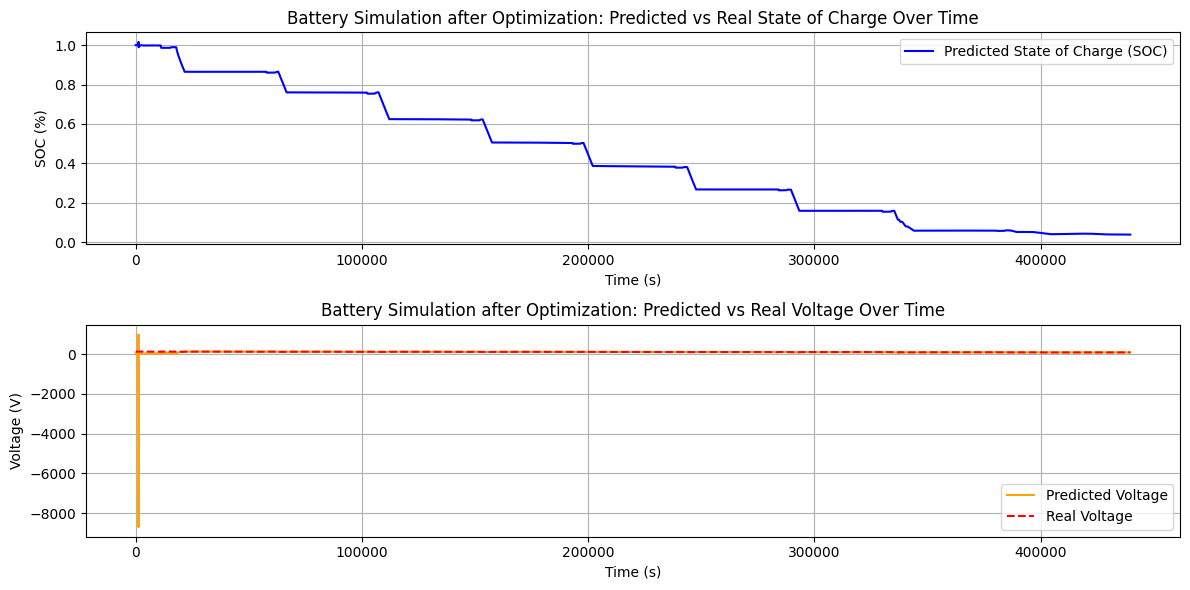

508.82744511804685


In [40]:
final_result = objective_voltage(final_params, visualize=True, optimized=True)
# plt.savefig("result.png")
print(final_result)
plt.show()

In [ ]:
battery_config = BatteryModelConfig(
    R_0_data=final_params[:10],  # Optimized R_0_data
    R_P_data=final_params[10:20],        # Optimized R_P
    C_P_data=final_params[20:30],        # Optimized C_P
    Q_total=nominal_charge_capacity,
    SOC_data=SOC_data,     # Hardcoded SOC data
    Uoc_data=final_params[30:40],# Optimized Uoc_data
    max_current_capacity=max_current_capacity,
    max_energy_capacity=max_energy_capacity
)
bm = BatteryModel(battery_config)

# Run Battery Model
soc_array, U_predicted = bm.update_array(power, power.granularity, rust=True)